## Kalashnik 1994


In [1]:
# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.colors import Normalize
# from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
from dask.diagnostics import ProgressBar
import zarr
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from scipy.signal import argrelextrema
from datetime import datetime

# Custom
import functions as f

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PARAMS = {'save_figs':       False,
#           'data_dir':        '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
          'ds_glob_path':    '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
#           'ds_glob_path_Rw': '/home/arthur/data/cyclobs/SAR_compilations_in_nc/ds_glob_Rw',
#           'save_dir':        '/home/arthur/results/ck22model/ck22model_scatter/lat30_cat1_allbasins/',
          
#           'filter_data':     True, # If True, filters out storms and TC > 30°N
}

### OPEN DATA
dsg = xr.open_dataset(PARAMS['ds_glob_path'])
# ds_glob = xr.open_dataset(PARAMS['ds_glob_path_Rw'])
print('Nb of storms: {}'.format(len(dsg.time)))

Nb of storms: 335


In [3]:
### FUNCTIONS
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def vorticity(r, v):
    '''Relative vorticity'''
    dr = 1000 # meters
    return (1 / r) * np.gradient(r * v, dr)

def h80(r, vm, rm, B, lat):
    '''Holland 1980 profile.'''
    fcor = coriolis(lat)
    V    = r * 0.
    V    = np.sqrt((vm ** 2) * ((rm / r) ** B) * np.exp(1 - (rm / r) ** B) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def rkne_x(r, vm, rm, x):
    '''Modified Rankine profile'''
    V          = vm * (r / rm)
    V_ou       = vm * (rm / r) ** x
    V[r >= rm] = V_ou[r >= rm]
    return V

## Holland

10704335.788999334
6461032.169779023
4142490.5466851215
2889499.359791915


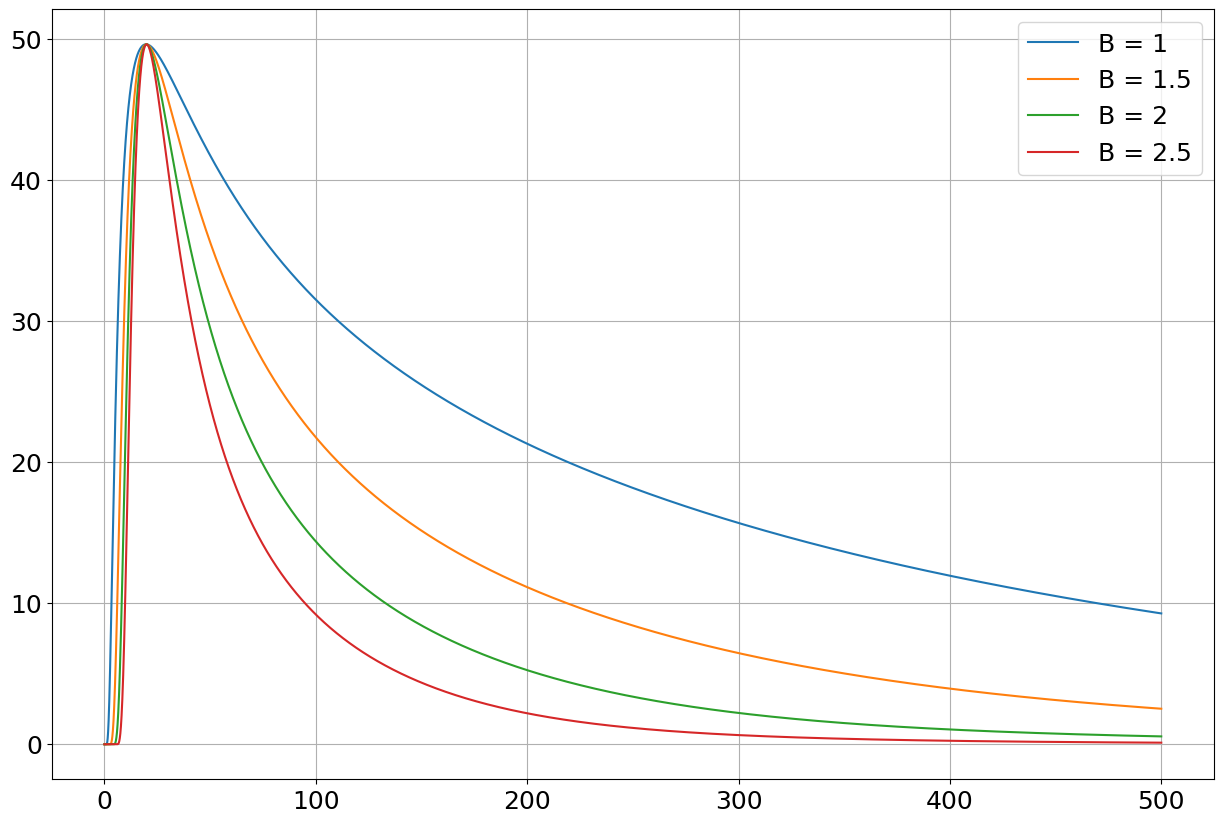

In [4]:
r   = np.linspace(0, 5e5, 50001)
B   = 1
vm  = 50
rm  = 20000
lat = 15
for B in [1, 1.5, 2, 2.5]:
    v = h80(r, vm, rm, B, lat)
    plt.plot(r / 1000, h80(r, vm, rm, B, lat), label='B = {}'.format(B))
    print(np.trapz(v[1:], x=r[1:]))
plt.grid();plt.legend()

In [5]:
def left_term(r, v):
    '''Integral of r v ^3'''
    return np.trapz(r[1:] * v[1:] ** 3, x=r[1:])

def right_term(r, v, lat):
    '''Right term'''
    r, v = r[1:], v[1:]
    dr   = 1000 # meters
    vort = (1 / r) * np.gradient(r * v, dr)
    q    = (r * v ** 2) / (vort + coriolis(lat))
    # idx  = np.argmax(q) # w_ekman zeroes when q reaches its maximum (because then derivative is null)
    return np.max(q)

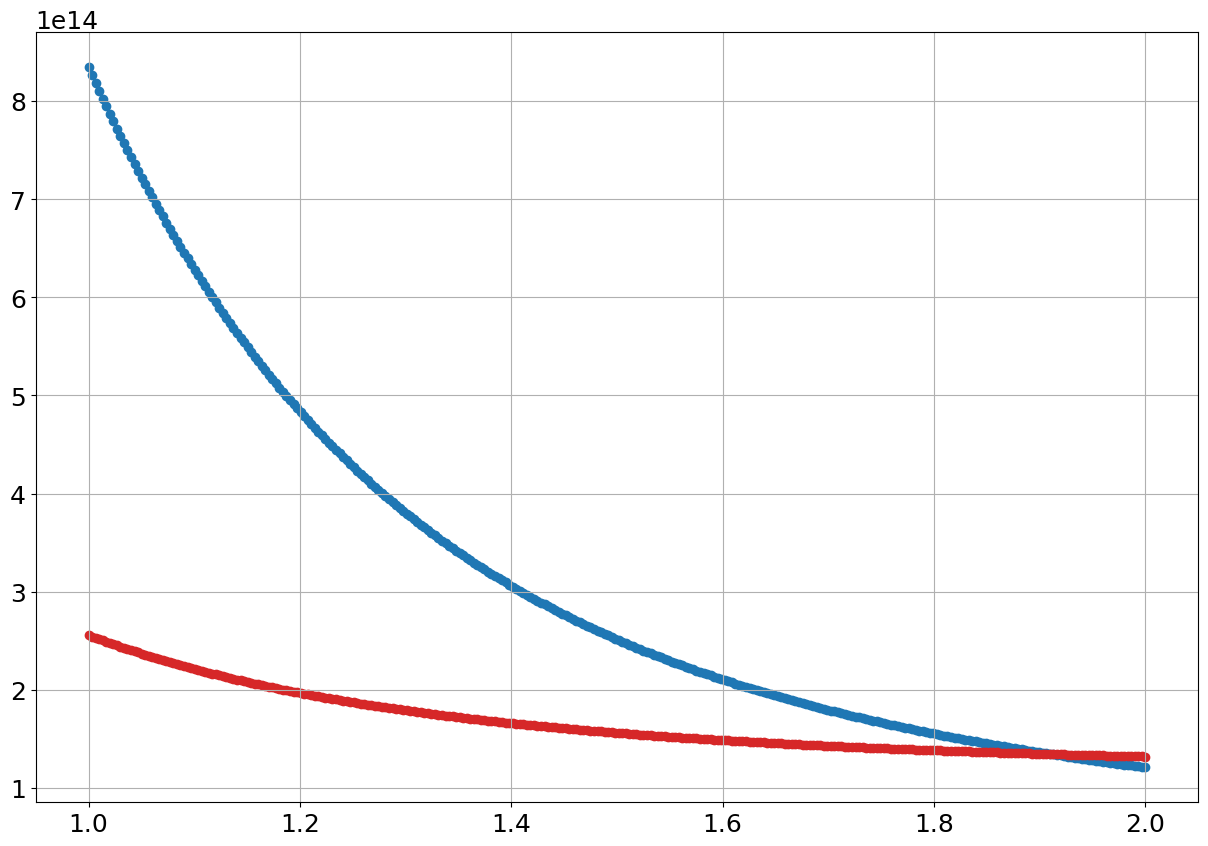

In [6]:
r   = np.linspace(0, 5e5, 50001)
vm  = 50
rm  = 20000
lat = 15
for B in np.linspace(1, 2, 300):
    v = h80(r, vm, rm, B, lat)
    plt.scatter(B, left_term(r, v), c='tab:blue')

for B in np.linspace(1, 2, 300):
    v = h80(r, vm, rm, B, lat)
    plt.scatter(B, 100 * right_term(r, v, lat), c='tab:red')
plt.grid()

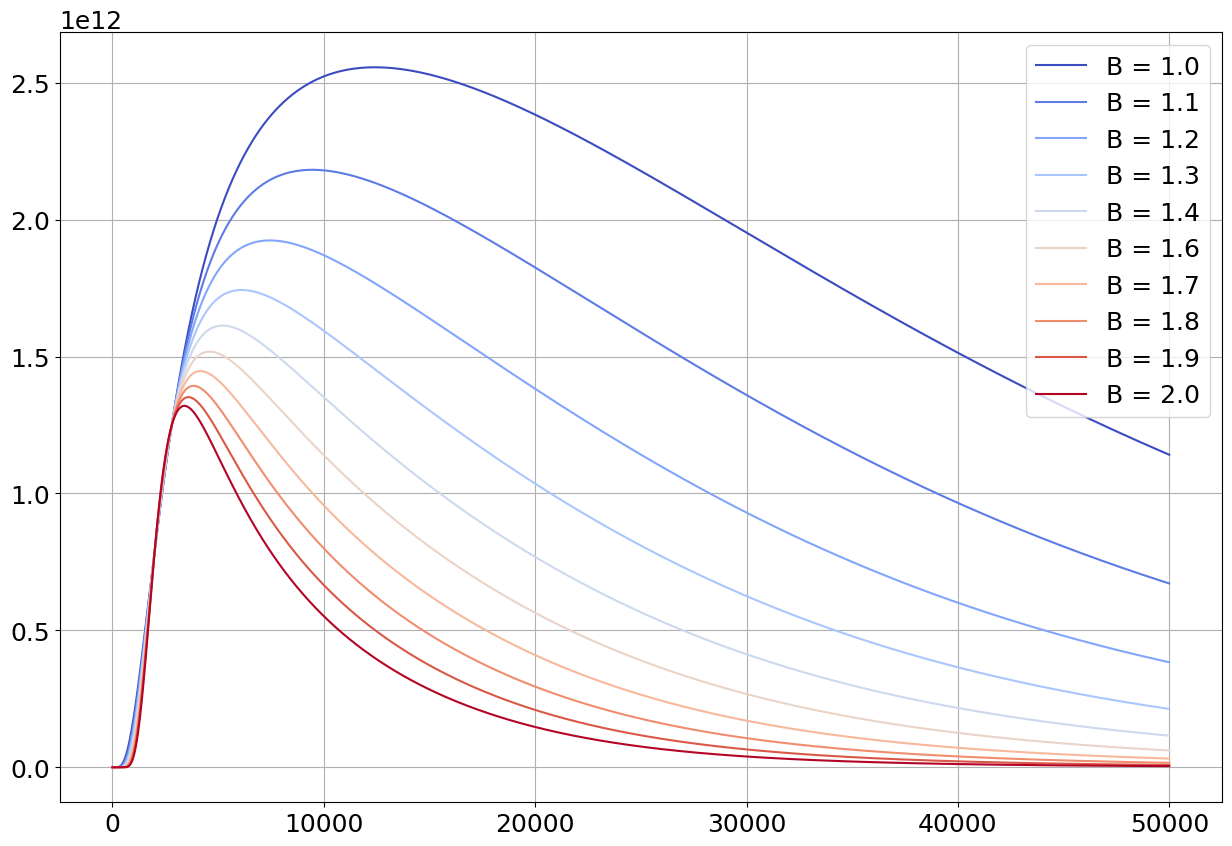

In [7]:
dr     = 1000 # meters
Bs     = np.linspace(1, 2, 10)
colors = mpl.cm.coolwarm(np.linspace(0, 1, len(Bs)))
for i, B in enumerate(Bs):
    v    = h80(r, vm, rm, B, lat)
    vort = (1 / r) * np.gradient(r * v, dr)
    # plt.plot(vort)
    # plt.plot(1 / (vort + coriolis(lat)), c=colors[i], label='B = {}'.format(B))
    q    = (r * v ** 2) / (vort + coriolis(lat))
    plt.plot(q, c=colors[i], label='B = {:.1f}'.format(B))
    # print(right_term(r, v, lat))
plt.legend()
plt.grid()

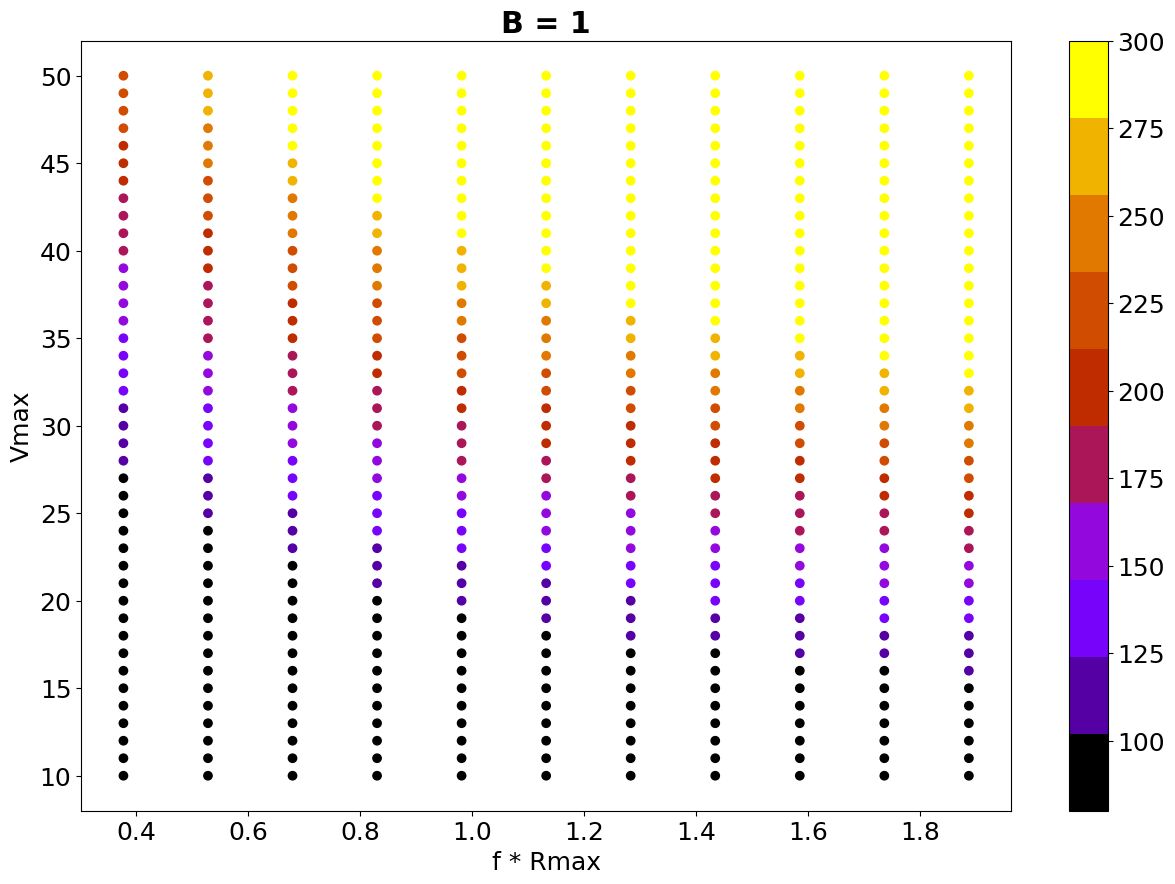

In [8]:
cmap = cm.get_cmap('gnuplot', 10)
r   = np.linspace(0, 5e5, 50001)
B   = 1
lat = 15

xs = []
ys = []
cs = []
for rm in np.linspace(10000, 50000, 11):
    for vm in np.linspace(10, 50, 41):
        v = h80(r, vm, rm, B, lat)
        xs.append(rm * coriolis(lat))
        ys.append(vm)
        cs.append(left_term(r, v) / right_term(r, v, lat))

plt.title('B = {}'.format(B), weight='bold')
plt.xlabel('f * Rmax');plt.ylabel('Vmax')
plt.scatter(xs, ys, c=cs, cmap=cmap, vmin=80, vmax=300);plt.colorbar()

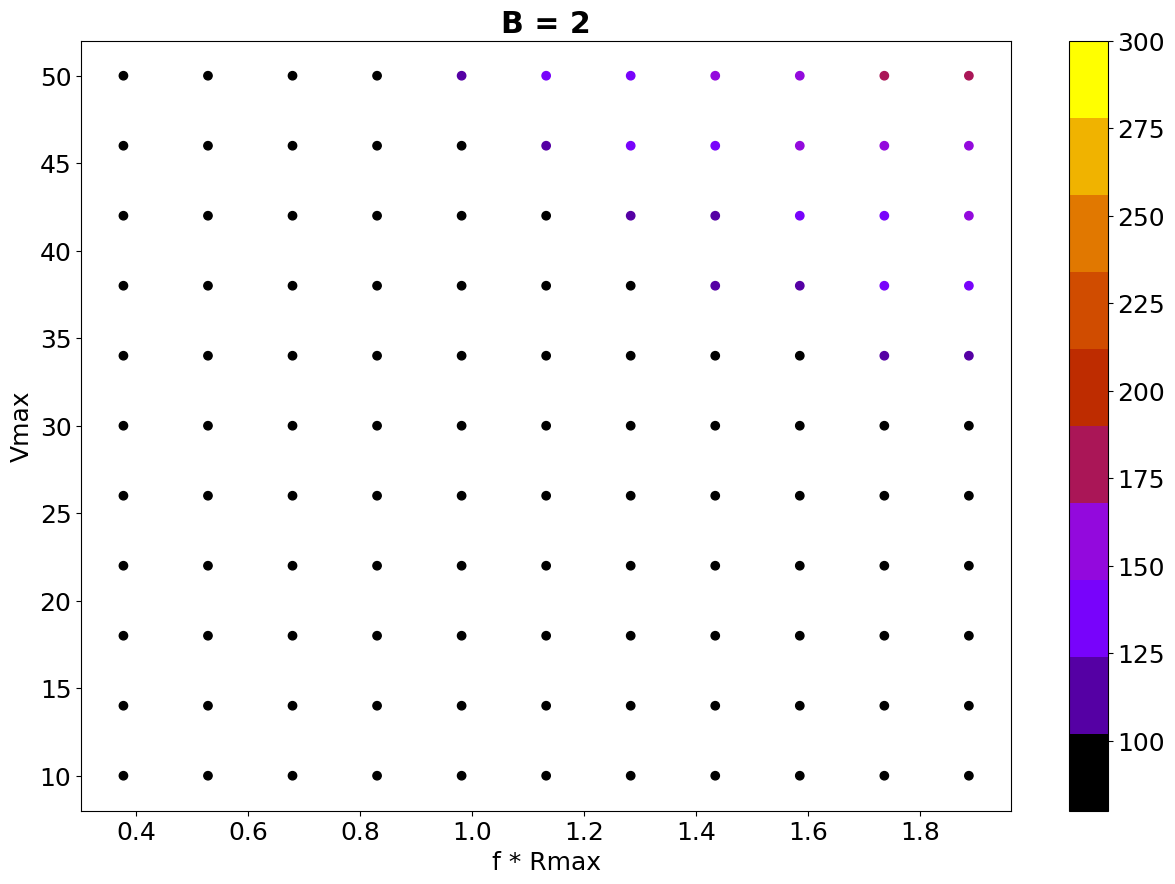

In [9]:
cmap = cm.get_cmap('gnuplot', 10)
r   = np.linspace(0, 5e5, 50001)
B   = 2
lat = 15

xs = []
ys = []
cs = []
for rm in np.linspace(10000, 50000, 11):
    for vm in np.linspace(10, 50, 11):
        v = h80(r, vm, rm, B, lat)
        xs.append(rm * coriolis(lat))
        ys.append(vm)
        cs.append(left_term(r, v) / right_term(r, v, lat))

plt.title('B = {}'.format(B), weight='bold')
plt.xlabel('f * Rmax');plt.ylabel('Vmax')
plt.scatter(xs, ys, c=cs, cmap=cmap, vmin=80, vmax=300);plt.colorbar()
# plt.contour([XS, YS], CS)

100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  3.28it/s]


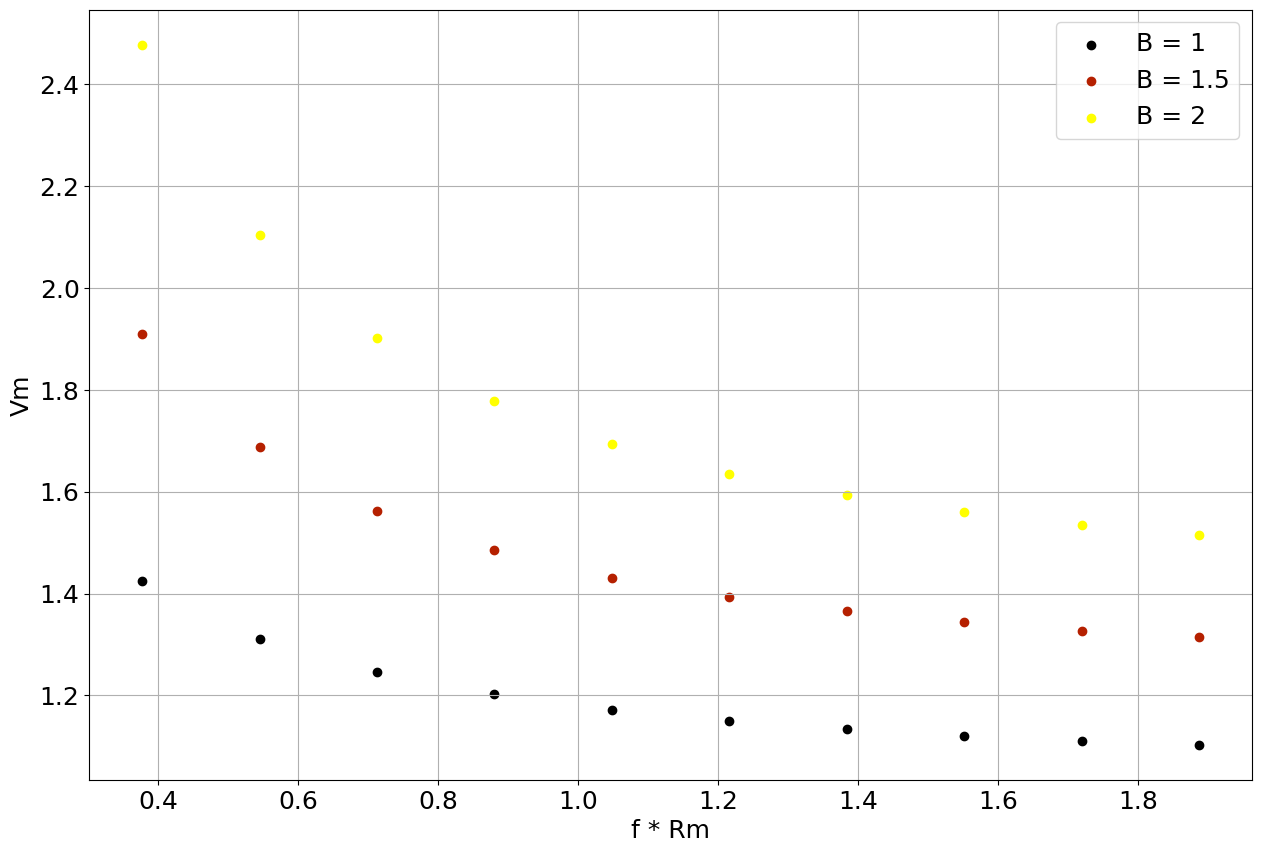

In [10]:
from scipy.optimize import minimize

def cost(vm, r, rm, B, lat):
    v = h80(r, vm, rm, B, lat)
    return left_term(r, v) - 2 * right_term(r, v, lat) # take at least 2, it doesn't work with 1

Bs     = [1, 1.5, 2]
colors = mpl.cm.gnuplot(np.linspace(0, 1, len(Bs)))
# colors = ['blue', 'red', 'green']
rm  = 20000
lat = 15

for i, B in enumerate(Bs):
    vms = []
    rms = []
    for rm in tqdm(np.linspace(10000, 50000, 10)):
        res = minimize(lambda vm: cost(vm, r, rm, B, lat), x0=1)
        vms.append(res.x)
        # print(res.success)
        rms.append(rm)
    plt.scatter(coriolis(lat) * np.array(rms), np.array(vms), color=colors[i], label='B = {}'.format(B))
plt.xlabel('f * Rm');plt.ylabel('Vm')
plt.grid()
plt.legend()

Text(0, 0.5, 'Vmax')

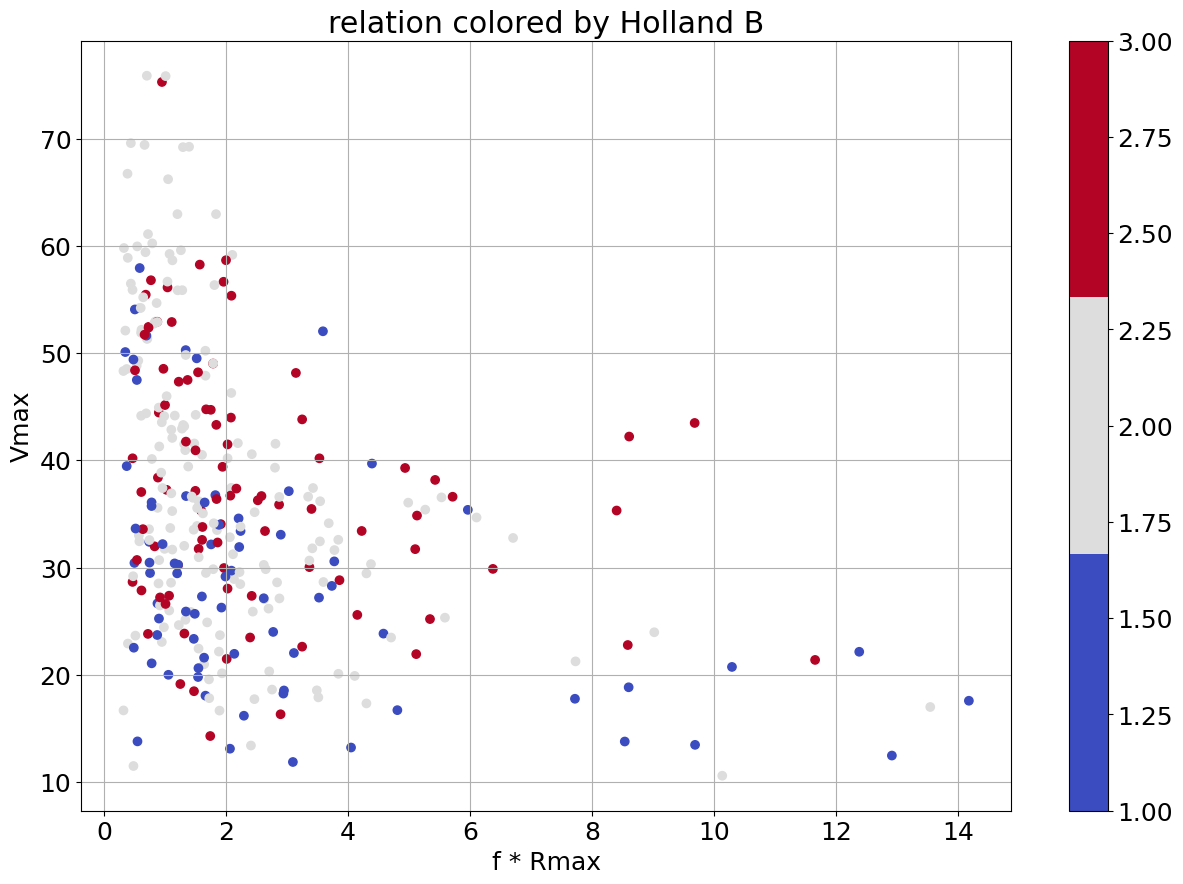

In [11]:
dsg['fcor'] = coriolis(dsg.lat_center)
plt.title('relation colored by Holland B')
plt.scatter(dsg.Rmax_1D * 1000 * abs(dsg.fcor), dsg.Vmax_1D, c=dsg.B_hol, vmin=1, vmax=3, cmap=cm.get_cmap('coolwarm', 3));plt.colorbar()
plt.grid()
plt.xlabel('f * Rmax');plt.ylabel('Vmax')
# plt.xlim(0.25, 8);plt.ylim(29, 80)

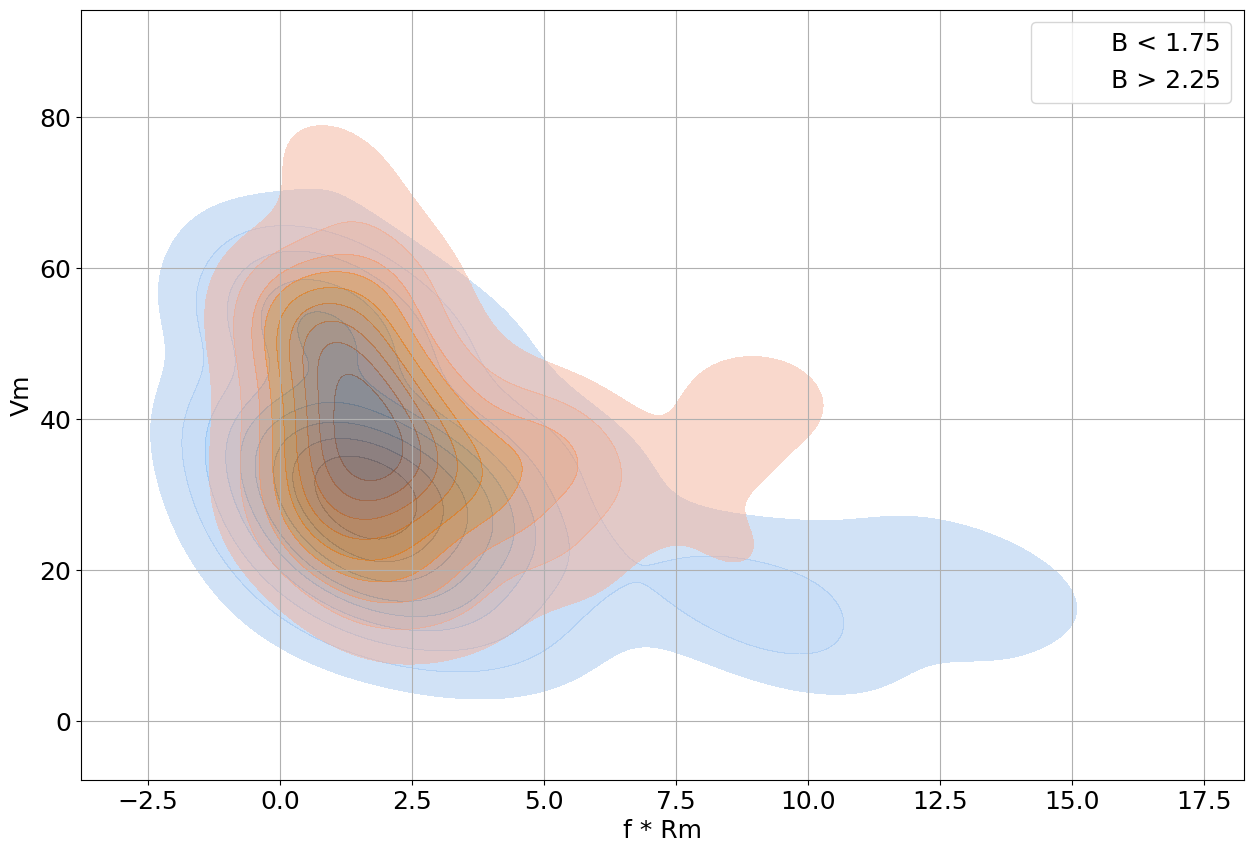

In [12]:
import seaborn as sns
d1 = dsg.where(dsg.B_hol < 1.75, drop=True)
d3 = dsg.where(dsg.B_hol > 2.25, drop=True)
sns.kdeplot(data=d1.B_hol, x=d1.Rmax_1D * 1000 * abs(d1.fcor), y=d1.Vmax_1D, fill=True, alpha=0.5, label='B < 1.75')
sns.kdeplot(data=d3.B_hol, x=d3.Rmax_1D * 1000 * abs(d3.fcor), y=d3.Vmax_1D, fill=True, alpha=0.5, label='B > 2.25')
plt.grid();plt.xlabel('f * Rm');plt.ylabel('Vm');plt.legend()

(array([ 1.,  0.,  1.,  1.,  2.,  2.,  5.,  3.,  4., 11.,  7.,  5., 14.,
        13.,  5., 24., 20., 23., 26., 25., 19., 14., 22., 16., 12., 14.,
         7.,  7.,  8.,  9.,  3.,  5.,  0.,  2.,  0.,  1.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([0.40958268, 0.4939519 , 0.57832112, 0.66269034, 0.74705956,
        0.83142879, 0.91579801, 1.00016723, 1.08453645, 1.16890567,
        1.25327489, 1.33764411, 1.42201333, 1.50638255, 1.59075177,
        1.67512099, 1.75949021, 1.84385944, 1.92822866, 2.01259788,
        2.0969671 , 2.18133632, 2.26570554, 2.35007476, 2.43444398,
        2.5188132 , 2.60318242, 2.68755164, 2.77192086, 2.85629009,
        2.94065931, 3.02502853, 3.10939775, 3.19376697, 3.27813619,
        3.36250541, 3.44687463, 3.53124385, 3.61561307, 3.69998229,
        3.78435151, 3.86872074, 3.95308996, 4.03745918, 4.1218284 ,
        4.20619762, 4.29056684, 4.37493606, 4.45930528, 4.5436745 ,
        4.62804372]),
 <BarContainer

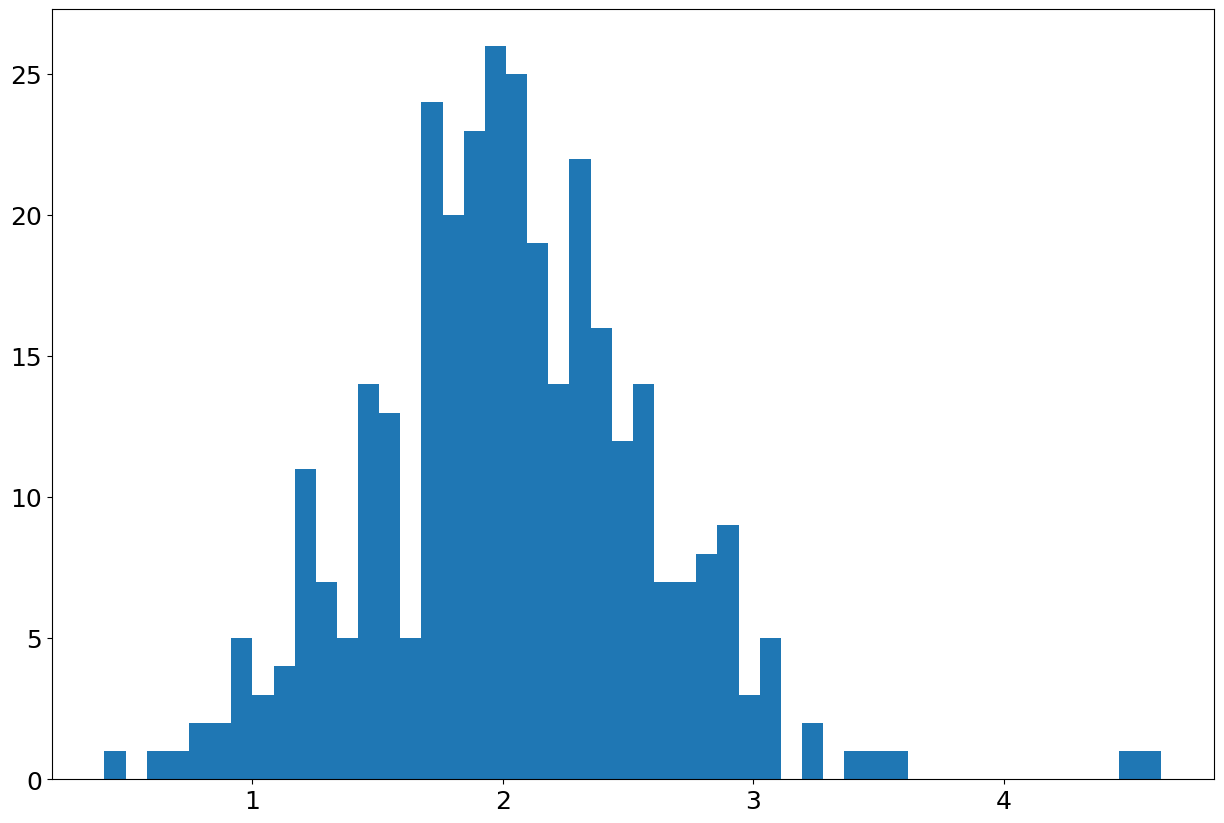

In [13]:
plt.hist(dsg.B_hol, bins=50)

Text(0, 0.5, 'Vmax')

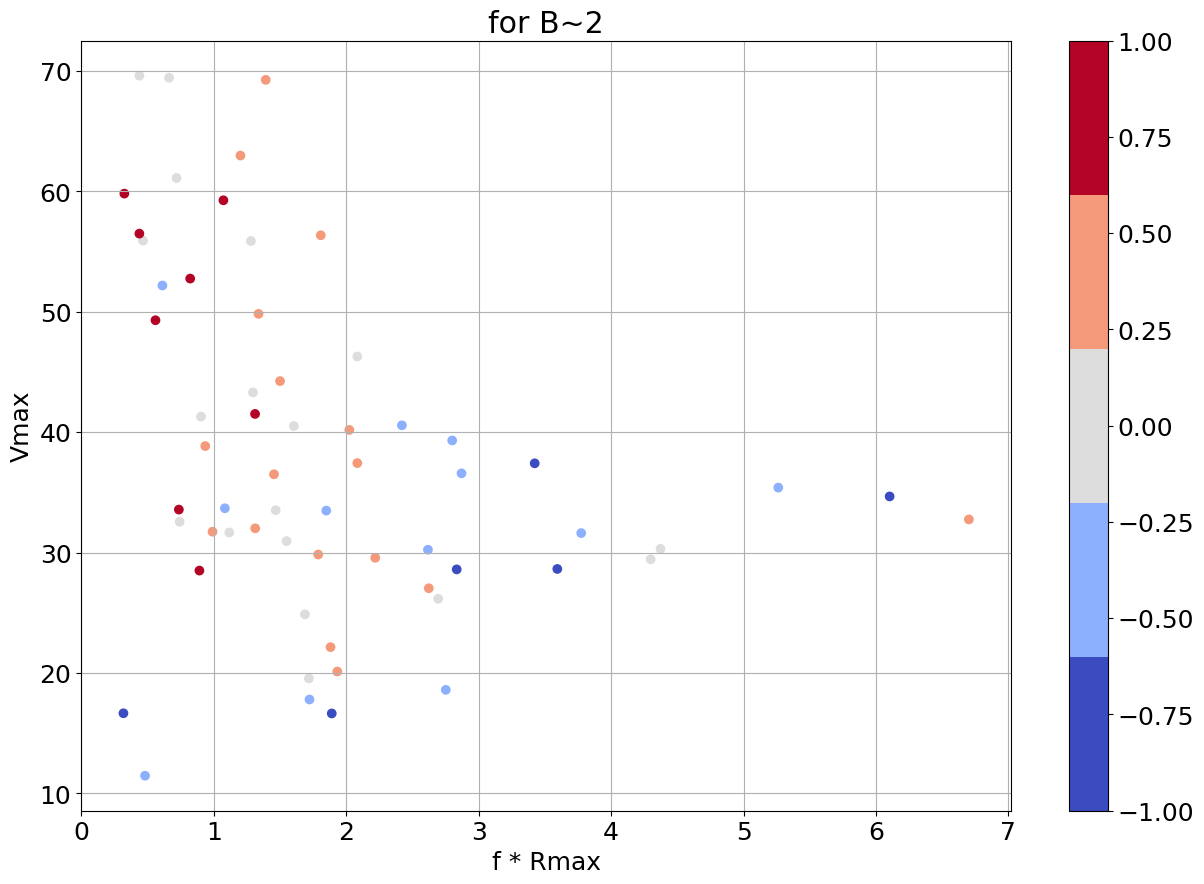

In [14]:
d = dsg.where(abs(dsg.B_hol - 2) < 0.1, drop=True)
plt.title('for B~2')
plt.scatter(d.Rmax_1D * 1000 * abs(d.fcor), d.Vmax_1D, c=d.curr_inten, cmap=cm.get_cmap('coolwarm', 5), vmin=-1, vmax=1);plt.colorbar()
plt.grid()
plt.xlabel('f * Rmax');plt.ylabel('Vmax')

Text(0, 0.5, 'Vmax')

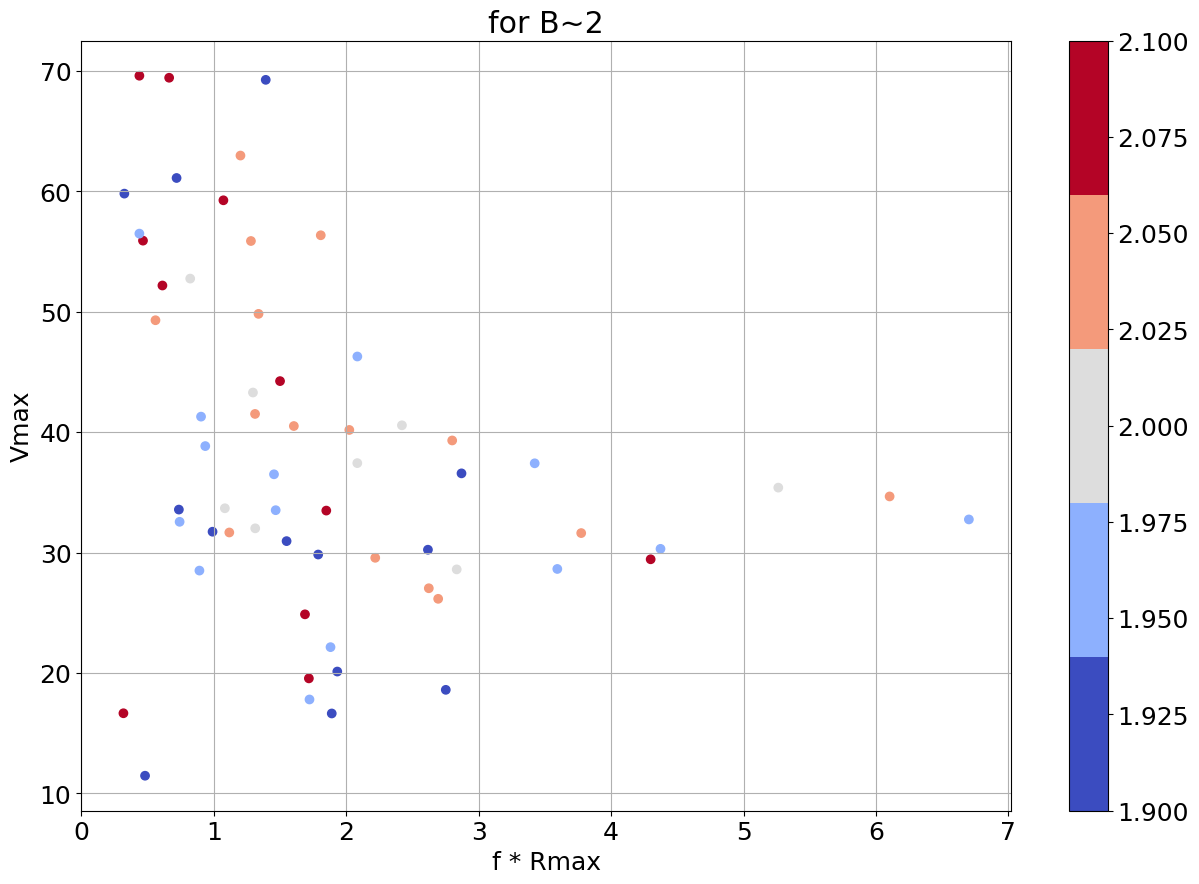

In [15]:
d = dsg.where(abs(dsg.B_hol - 2) < 0.1, drop=True)
plt.title('for B~2')
plt.scatter(d.Rmax_1D * 1000 * abs(d.fcor), d.Vmax_1D, c=d.B_hol, cmap=cm.get_cmap('coolwarm', 5), vmin=1.9, vmax=2.1);plt.colorbar()
plt.grid()
plt.xlabel('f * Rmax');plt.ylabel('Vmax')

Text(0, 0.5, 'Vmax')

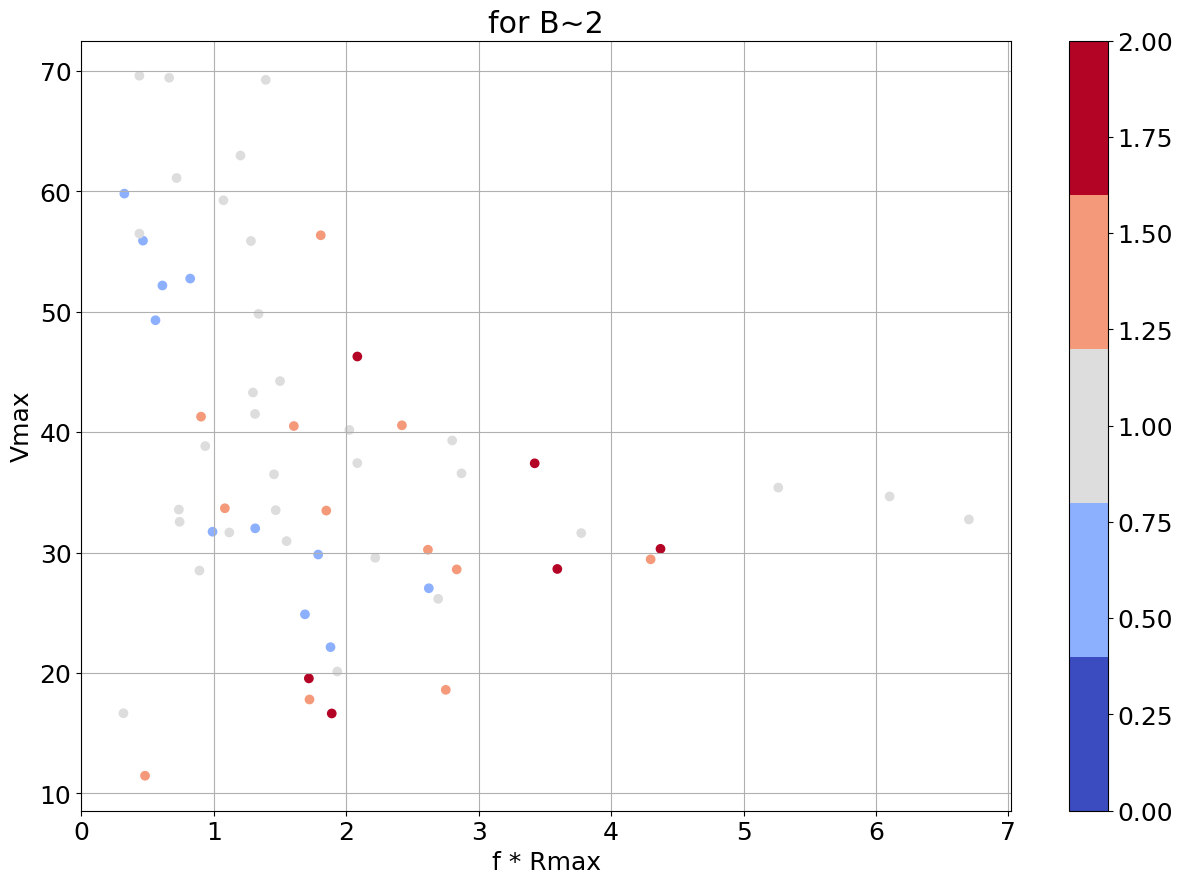

In [16]:
d = dsg.where(abs(dsg.B_hol - 2) < 0.1, drop=True)
plt.title('for B~2')
plt.scatter(d.Rmax_1D * 1000 * abs(d.fcor), d.Vmax_1D, c=d.life_vmax_idx, cmap=cm.get_cmap('coolwarm', 5), vmin=0, vmax=2);plt.colorbar()
plt.grid()
plt.xlabel('f * Rmax');plt.ylabel('Vmax')

Text(0, 0.5, 'Vmax')

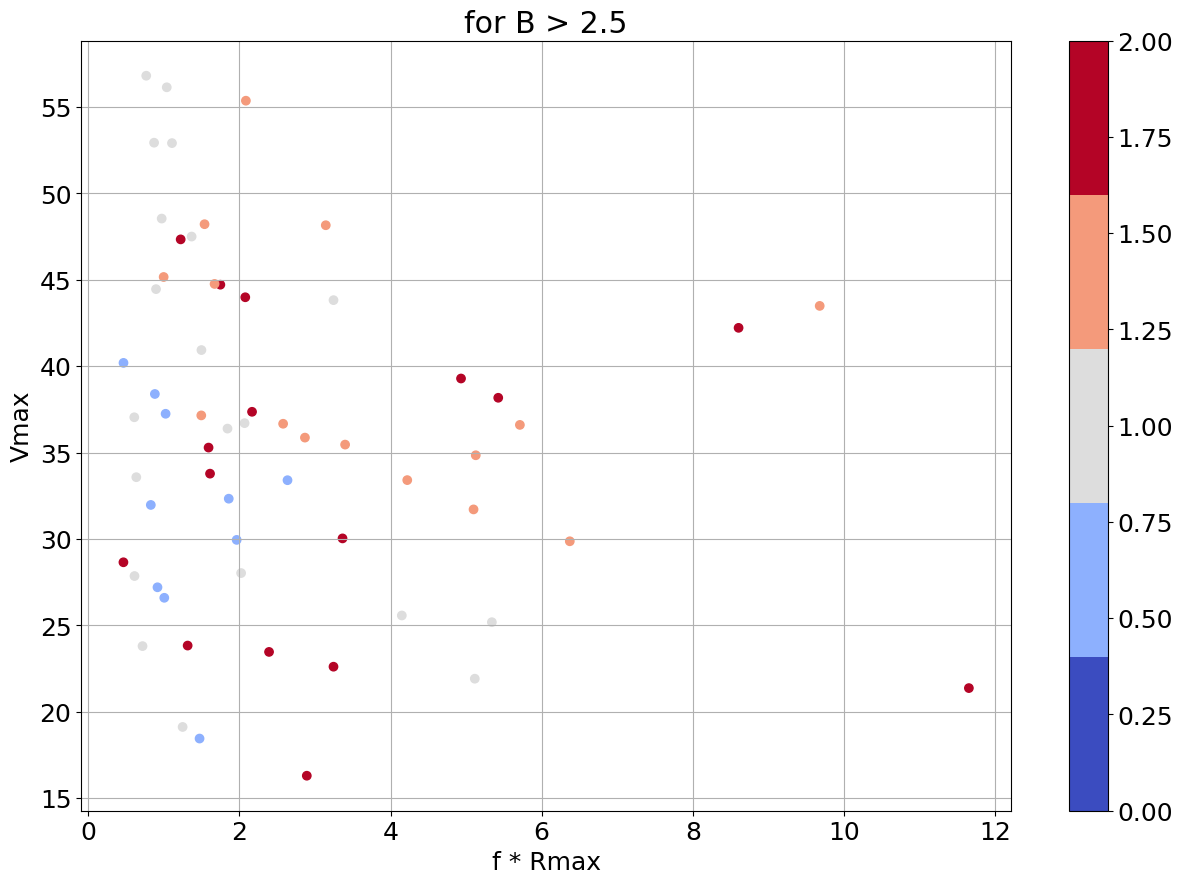

In [17]:
d = dsg.where(dsg.B_hol > 2.5, drop=True)
plt.title('for B > 2.5')
plt.scatter(d.Rmax_1D * 1000 * abs(d.fcor), d.Vmax_1D, c=d.life_vmax_idx, cmap=cm.get_cmap('coolwarm', 5), vmin=0, vmax=2);plt.colorbar()
plt.grid()
plt.xlabel('f * Rmax');plt.ylabel('Vmax')

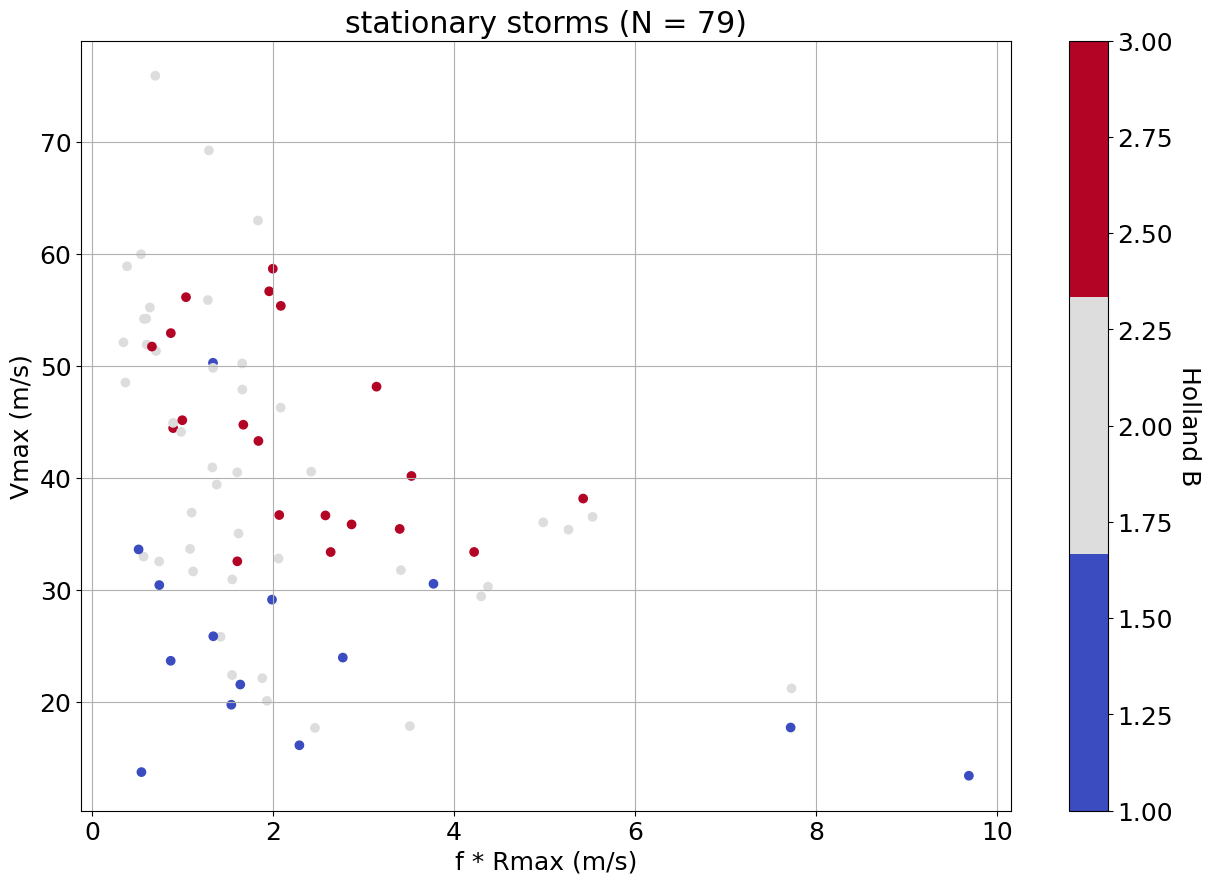

In [18]:
### WITH SOME HYPOTHESES
dsg2 = xr.open_dataset('/home/arthur/results/TCsLifeMonitFromObs/07_SAR_K10/ds_glob.nc')
dsg['Vmax_dot_smth_IBT'] = dsg2['Vmax_dot_smth_IBT']

d = dsg.where(abs(dsg.Vmax_dot_smth_IBT) < 0.3, drop=True)
d = d.where(abs(d.lat_center) < 30, drop=True)
d = d.where(d.distance_to_coast > 200000, drop=True)
plt.title('stationary storms (N = {})'.format(len(d.time)))
plt.scatter(d.Rmax_1D * 1000 * abs(d.fcor), d.Vmax_1D, c=d.B_hol, vmin=1, vmax=3, cmap=cm.get_cmap('coolwarm', 3))
plt.grid()
plt.xlabel('f * Rmax (m/s)');plt.ylabel('Vmax (m/s)')

cbar    = plt.colorbar()
cbar.set_label('Holland B', rotation=270)
cbar.ax.get_yaxis().labelpad=20

In [19]:
# from scipy.interpolate import griddata

# x = np.linspace(0, 10, 51)
# y = np.linspace(5, 80, 301)
# X, Y = np.meshgrid(x, y)

# d2 = d.dropna(dim='time', subset=['Rmax_1D', 'Vmax_1D'], how='any')

# b  = griddata((d2.Rmax_1D * 1000 * abs(d2.fcor), d2.Vmax_1D), d2.B_hol, (X, Y), method='linear')
# plt.pcolormesh(X, Y, b, cmap=cm.get_cmap('coolwarm'));plt.colorbar()
# plt.grid()

In [20]:
# plt.title('stationary storms (N = {})'.format(len(d.time)))
# plt.scatter(d.Rmax_1D * 1000 * abs(d.fcor), d.Vmax_1D, c=d.B_hol, vmin=1, vmax=3, cmap=cm.get_cmap('coolwarm', 3), marker='s', s=200)
# plt.grid()
# plt.xlabel('f * Rmax (m/s)');plt.ylabel('Vmax (m/s)')

# cbar    = plt.colorbar()
# cbar.set_label('Holland B', rotation=270)
# cbar.ax.get_yaxis().labelpad=20

In [21]:
d.where(d.Rmax_1D * 1000 * abs(d.fcor) > 6, drop=True).Vmax_1D

<xarray.DataArray 'Vmax_1D' (time: 3)>
array([17.7496574 , 21.24094853, 13.44865959])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-02T18:56:10 ... 2020-09-20T00:09:46

## Modified Rankine

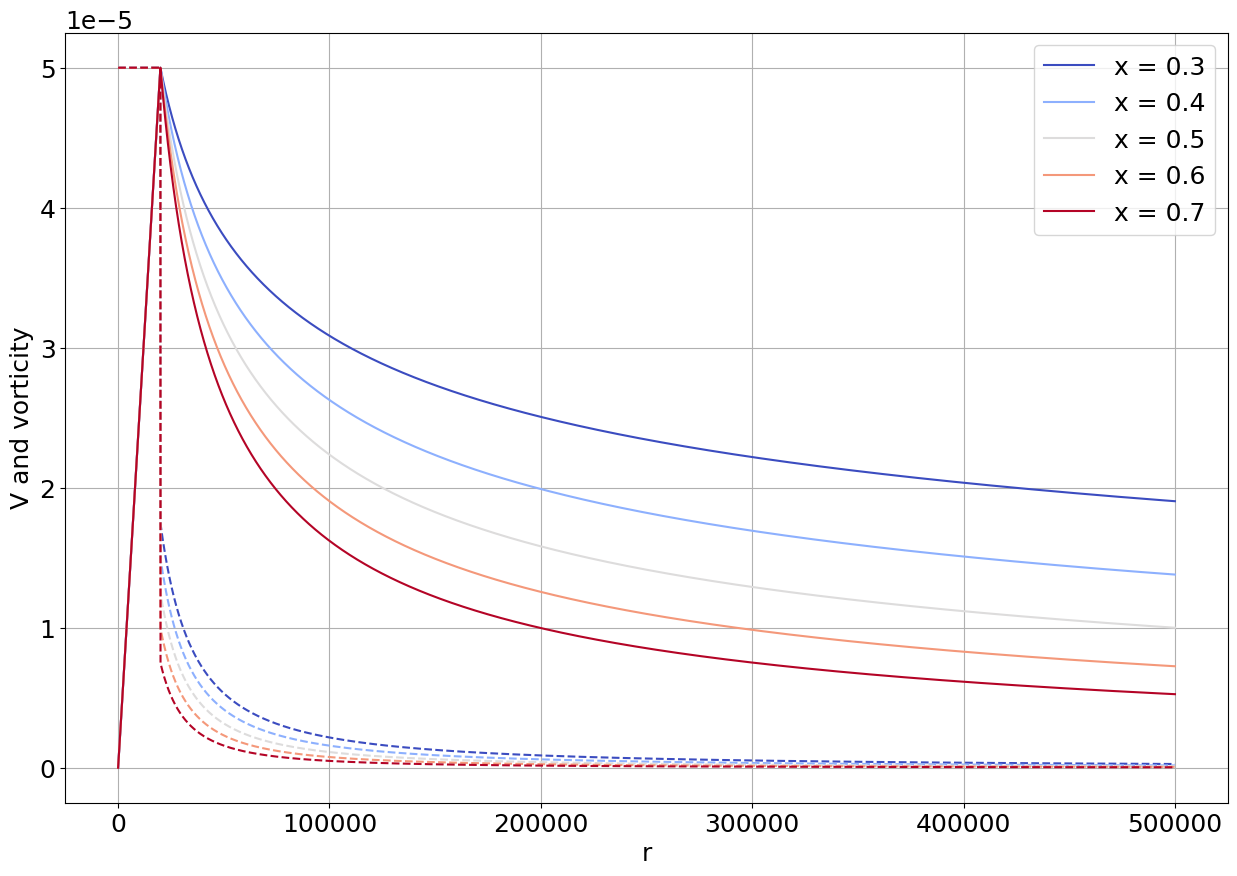

In [22]:
r      = np.linspace(0, 5e5, 50001)
vm     = 50
rm     = 20000
xs     = np.linspace(0.3, 0.7, 5)
colors = mpl.cm.coolwarm(np.linspace(0, 1, len(xs)))

for i, x in enumerate(xs):
    plt.plot(r, rkne_x(r, vm, rm, x) / 1e6, c=colors[i], label='x = {:.1f}'.format(x))
    plt.plot(r, vorticity(r, rkne_x(r, vm, rm, x)), c=colors[i], linestyle='--')
plt.xlabel('r');plt.ylabel('V and vorticity');plt.grid();plt.legend()

In [23]:
def vm_x(lat, rm, x):
    '''With outer-core form for vorticity'''
    frm = coriolis(lat) * rm
    num = - frm + np.sqrt(frm ** 2 + (20 * (1 - x)) / (1 + 5 * rm ** (3 * x - 3)))
    den = 2 - 2 * x
    return num / den

def vm_x_bis(lat, rm, x):
    '''With inner-core form for vorticity'''
    frm = coriolis(lat) * rm
    num = - frm + np.sqrt(frm ** 2 + (40) / (1 + 5 * rm ** (3 * x - 3)))
    den = 4
    return num / den

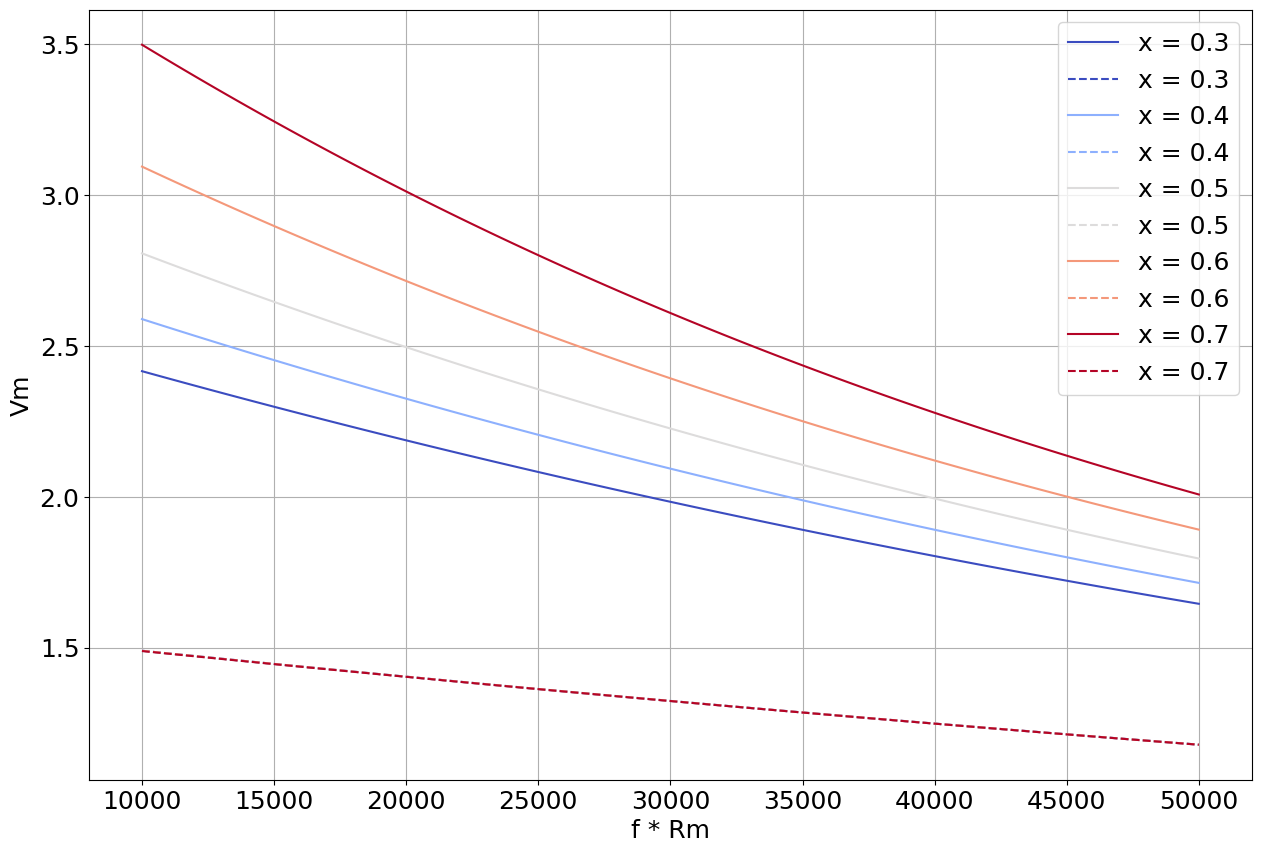

In [24]:
lat    = 15
rms    = np.linspace(10000, 50000, 101)
xs     = np.linspace(0.3, 0.7, 5)
colors = mpl.cm.coolwarm(np.linspace(0, 1, len(xs)))
for i, x in enumerate(xs):
    vms     = vm_x(lat, rms, x)
    vms_bis = vm_x_bis(lat, rms, x)
    plt.plot(rms, vms,     c=colors[i], label='x = {:.1f}'.format(x))
    plt.plot(rms, vms_bis, c=colors[i], label='x = {:.1f}'.format(x), linestyle='--')
plt.xlabel('f * Rm');plt.ylabel('Vm');plt.grid();plt.legend()

#### Test

In [25]:
r    = np.linspace(0, 5e5, 50001)
dr   = 1000 # meters

vms  = np.linspace(20, 70, 11)
rms  = np.linspace(10000, 50000, 11)
lats = np.linspace(10, 20, 5)
Bs   = np.linspace(1, 2, 11)

In [26]:
X, _, _, _ = np.meshgrid(vms, rms, lats, Bs)
L          = np.empty_like(X)

In [27]:
for i, vm in tqdm(enumerate(vms)):
    for j, rm in enumerate(rms):
        for k, lat in enumerate(lats):
            for l, B in enumerate(Bs):
                v    = h80(r, vm, rm, B, lat)
                vort = (1 / r) * np.gradient(r * v, dr)
                q    = (r * v ** 2) / (vort + coriolis(lat))
                L[i, j, k, l] = r[np.nanargmax(q)]

11it [00:28,  2.61s/it]


In [28]:
ds = xr.Dataset(
    data_vars={
        'L': (('vmx', 'rmx', 'lat', 'B'), L)
    },
    coords={
        'vmx': vms,
        'rmx': rms,
        'lat': lats,
        'B':   Bs
    }
)

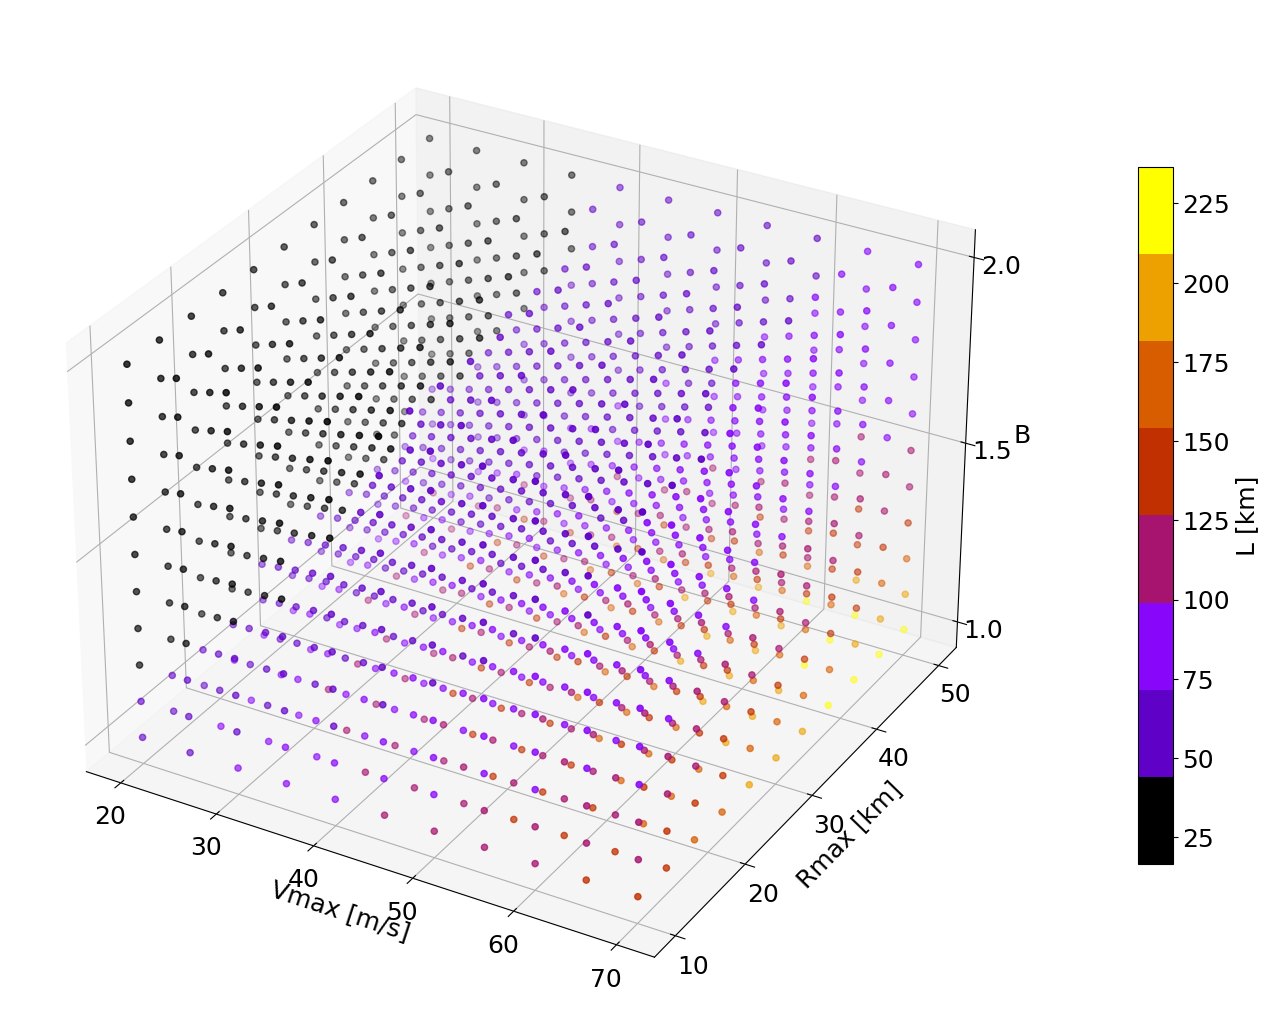

In [29]:
d = ds.isel(lat=2)
xs, ys, zs = np.meshgrid(d.vmx, d.rmx, d.B)

fig = plt.figure(figsize=(15, 14))
ax  = fig.add_subplot(111, projection='3d')
im  = ax.scatter(xs, ys / 1000, zs, c=d.L / 1000, cmap=cm.get_cmap('gnuplot', 8))
ax.set(
    xlabel='Vmax [m/s]',
    ylabel='Rmax [km]',
    zlabel='B',
    xticks=np.linspace(20, 70, 6),
    yticks=np.linspace(10, 50, 5),
    zticks=np.linspace(1, 2, 3),
)
fig.colorbar(im, ax=ax, fraction=0.03, pad=0.1, label='L [km]')

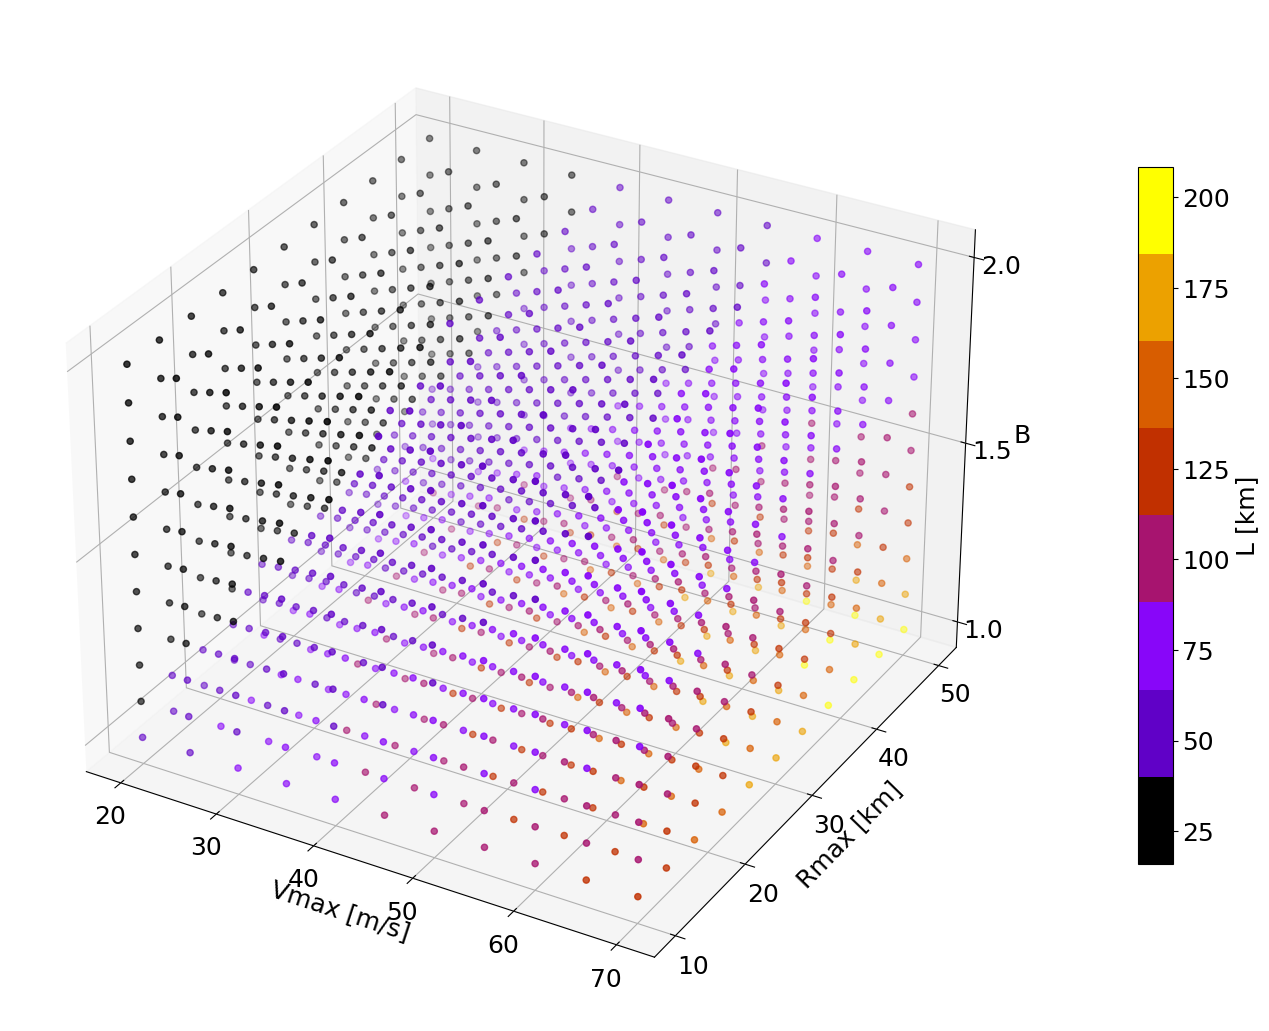

In [30]:
d = ds.isel(lat=4)
xs, ys, zs = np.meshgrid(d.vmx, d.rmx, d.B)

fig = plt.figure(figsize=(15, 14))
ax  = fig.add_subplot(111, projection='3d')
im  = ax.scatter(xs, ys / 1000, zs, c=d.L / 1000, cmap=cm.get_cmap('gnuplot', 8))
ax.set(
    xlabel='Vmax [m/s]',
    ylabel='Rmax [km]',
    zlabel='B',
    xticks=np.linspace(20, 70, 6),
    yticks=np.linspace(10, 50, 5),
    zticks=np.linspace(1, 2, 3),
)
fig.colorbar(im, ax=ax, fraction=0.03, pad=0.1, label='L [km]')

In [31]:
# for i, vm in tqdm(enumerate(vms)):
#     for j, rm in enumerate(rms):
#         for k, lat in enumerate(lats):
#             for l, B in enumerate(Bs):
#                 v    = h80(r, vm, rm, B, lat)
#                 vort = (1 / r) * np.gradient(r * v, dr)
#                 q    = (r * v ** 2) / (vort + coriolis(lat))
#                 plt.plot(q)
#                 L[i, j, k, l] = r[np.argmax(q)]

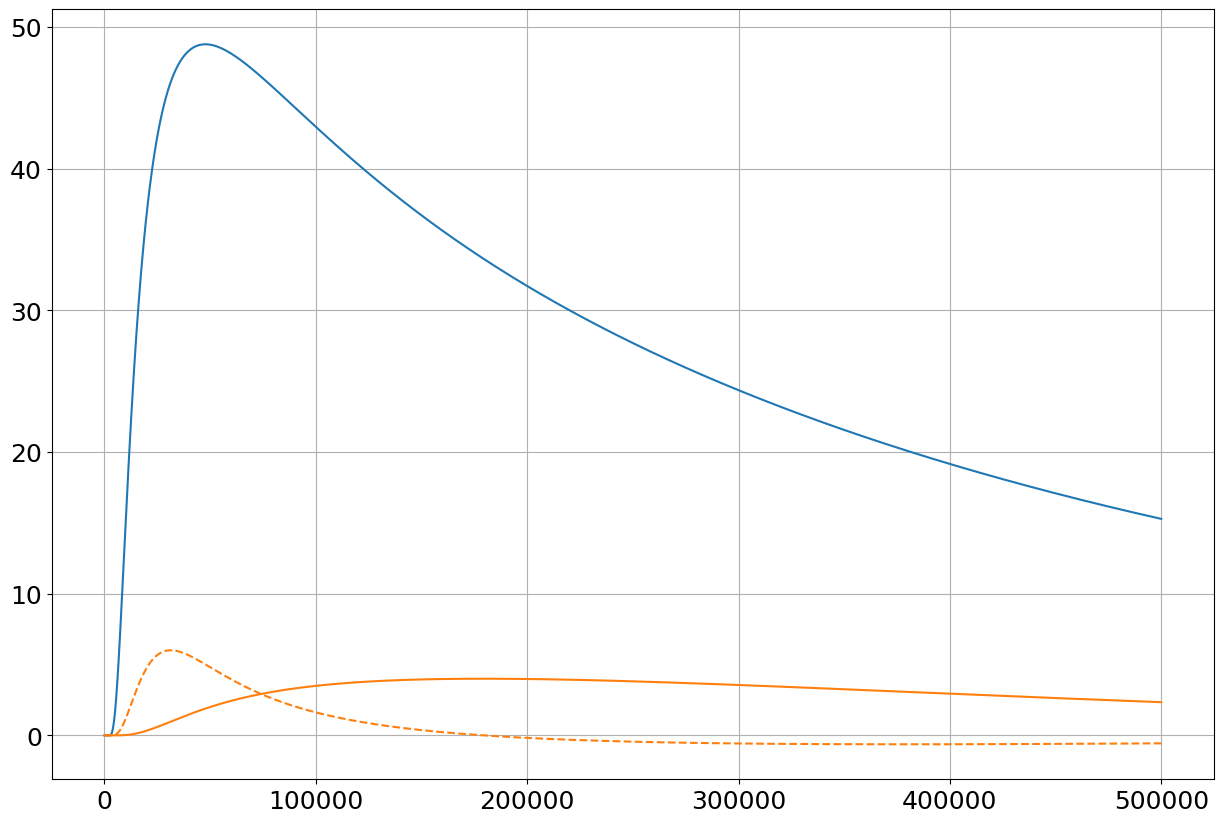

In [129]:
v    = h80(r, 50, 50000, 1, 20)
vort = (1 / r) * np.gradient(r * v, dr)
q    = (r * v ** 2) / (vort + coriolis(lat))

plt.plot(r, v, c='tab:blue')
plt.plot(r, q / 1e12, c='tab:orange')
plt.plot(r, np.gradient(q, dr) / 1e5, c='tab:orange', linestyle='--')
plt.grid()

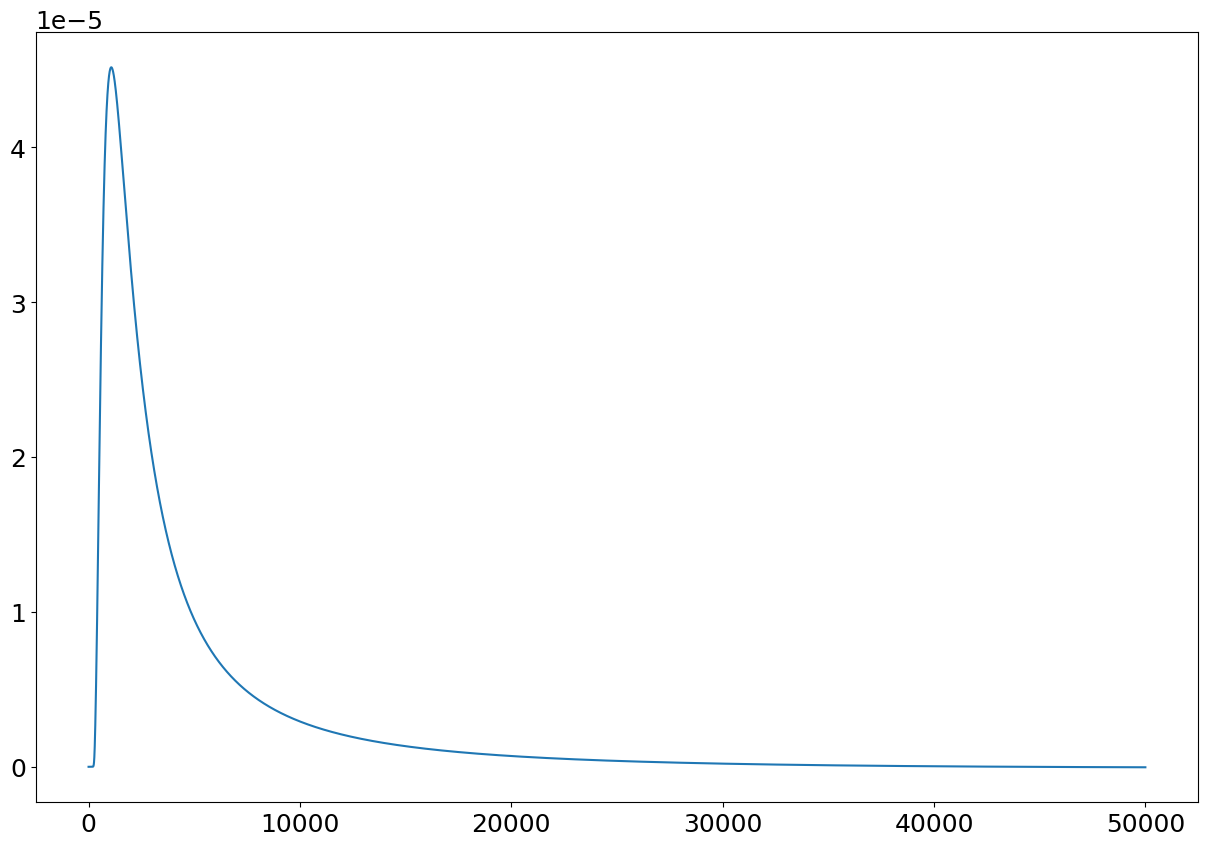

In [133]:
plt.plot(vort)

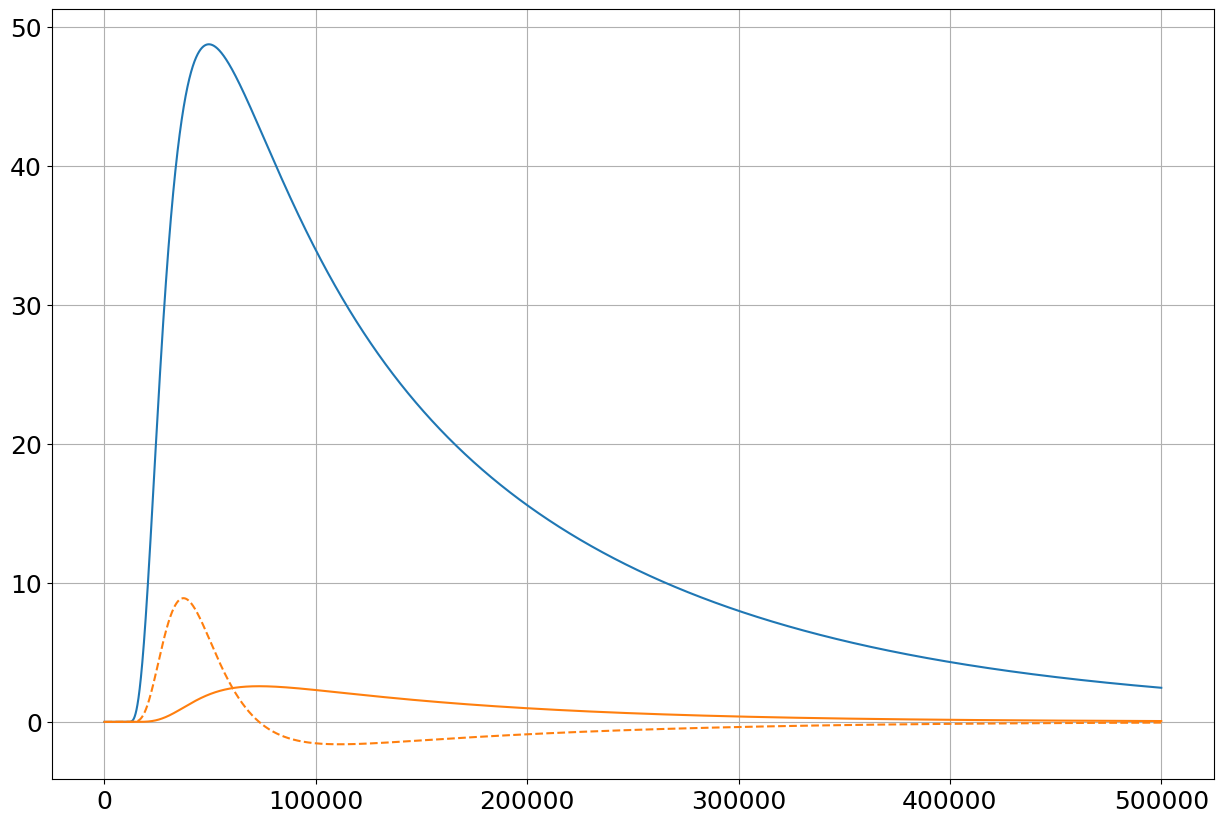

In [99]:
def h80(r, vm, rm, B, lat):
    '''Holland 1980 profile.'''
    fcor = coriolis(lat)
    V    = r * 0.
    V    = np.sqrt((vm ** 2) * ((rm / r) ** B) * np.exp(1 - (rm / r) ** B) + ((r * fcor / 2) ** 2)) - (r * fcor / 2)
    return V

v    = h80(r, 50, 50000, 2, 20)
vort = (1 / r) * np.gradient(r * v, dr)
q    = (r * (v ** 2)) / (vort + coriolis(lat))

plt.plot(r, v, c='tab:blue')
plt.plot(r, q / 1e12, c='tab:orange')
plt.plot(r, np.gradient(q, dr) / 1e5, c='tab:orange', linestyle='--')
plt.grid()

# q_bis = (r * (v ** 2)) / coriolis(lat)
# plt.plot(r, np.gradient(q_bis, dr) / 1e5, c='tab:red', linestyle='--')

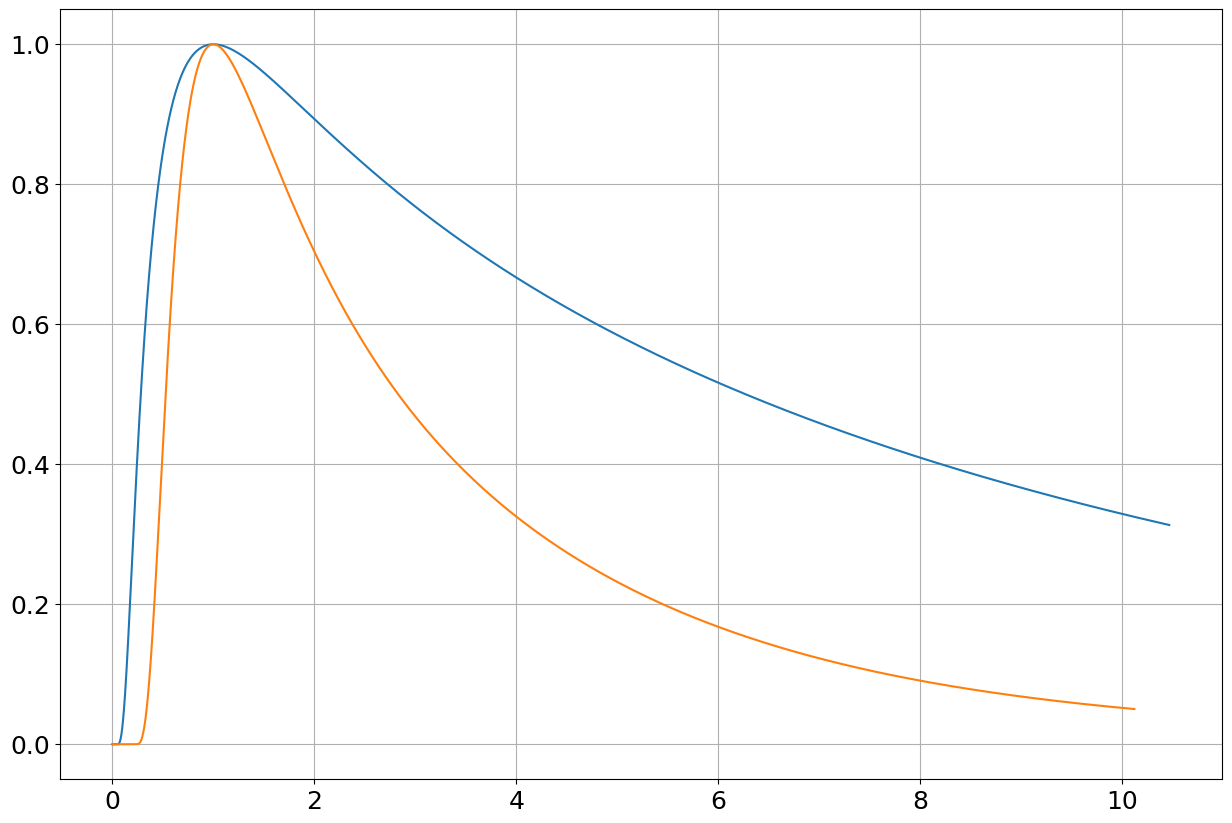

In [60]:
v1 = h80(r, 50, 50000, 1, 20)
v2 = h80(r, 50, 50000, 2, 20)
plt.plot(r / r[np.nanargmax(v1)], v1 / np.nanmax(v1), c='tab:blue')
plt.plot(r / r[np.nanargmax(v2)], v2 / np.nanmax(v2), c='tab:orange')
plt.grid()

In [37]:
# v    = h80(r, 50, 50000, 2, 20)
# vort = (1 / r) * np.gradient(r * v, dr)
# q    = (r * v ** 2) / (vort + coriolis(lat))

# plt.plot(r, v, c='tab:blue')
# plt.plot(r, q / 1e12, c='tab:orange')
# plt.plot(r, np.gradient(q, dr) / 1e5, c='tab:orange', linestyle='--')
# plt.grid()

In [35]:
# v    = h80(r, 22, 50000, 1, 20)
# vort = (1 / r) * np.gradient(r * v, dr)
# q    = (r * v ** 2) / (vort + coriolis(lat))

# plt.plot(r, v, c='tab:blue')
# plt.plot(r, q / 1e12, c='tab:orange')
# plt.plot(r, np.gradient(q, dr) / 1e5, c='tab:orange', linestyle='--')
# plt.grid()

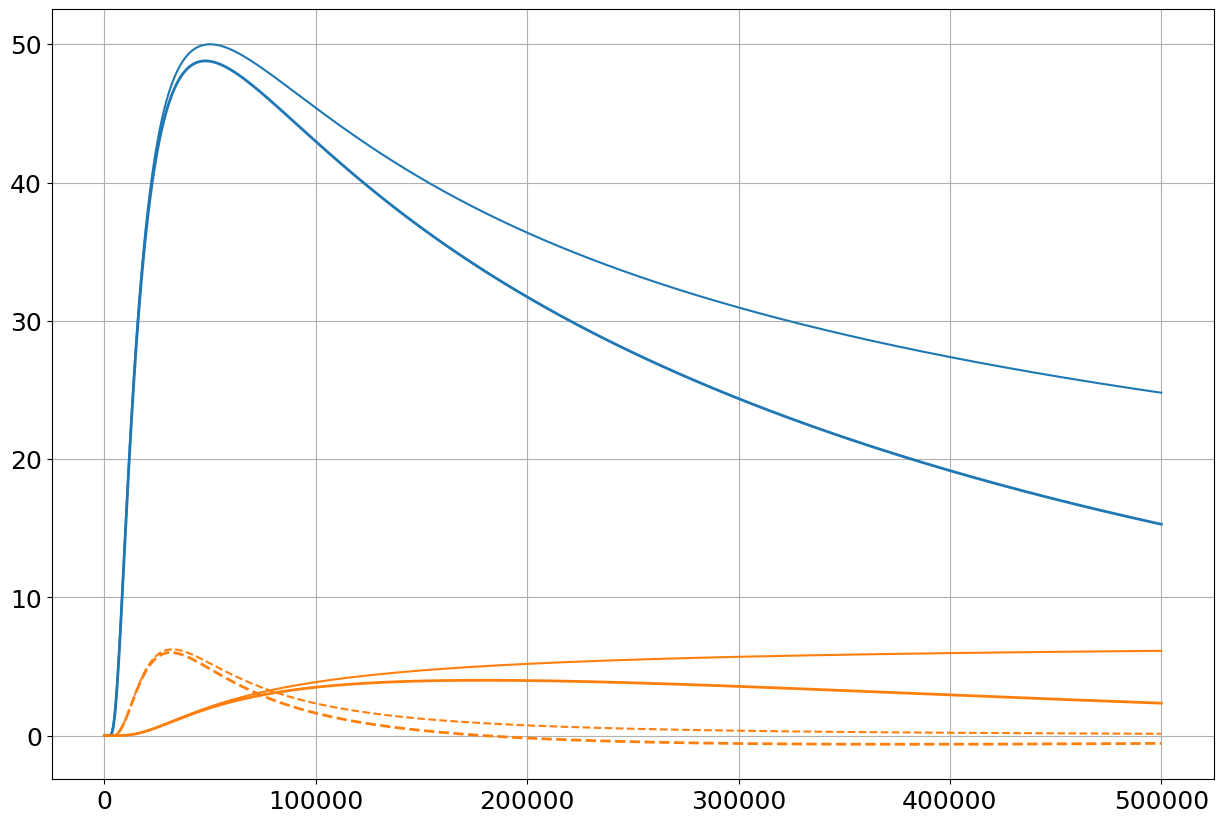

In [128]:
### WITH OR WITHOUT CORIOLIS TERMS
def h80(r, vm, rm, B, lat):
    '''Holland 1980 profile.'''
    fcor = coriolis(lat)
    V    = r * 0.
    V    = np.sqrt((vm ** 2) * ((rm / r) ** B) * np.exp(1 - (rm / r) ** B) + ((r * fcor / 2) ** 2)) - (r * fcor / 2)
    return V

def h802(r, vm, rm, B, lat):
    '''Holland 1980 profile.'''
    fcor = coriolis(lat)
    V    = r * 0.
    V    = np.sqrt((vm ** 2) * ((rm / r) ** B) * np.exp(1 - (rm / r) ** B))
    return V


v    = h80(r, 50, 50000, 1, 20)
vort = (1 / r) * np.gradient(r * v, dr)
q    = (r * (v ** 2)) / (vort + coriolis(lat))

plt.plot(r, v, c='tab:blue', linewidth=2)
plt.plot(r, q / 1e12, c='tab:orange', linewidth=2)
plt.plot(r, np.gradient(q, dr) / 1e5, c='tab:orange', linestyle='--', linewidth=2)

v2    = h802(r, 50, 50000, 1, 20)
vort2 = (1 / r) * np.gradient(r * v2, dr)
q2    = (r * (v2 ** 2)) / (vort2 + coriolis(lat))

plt.plot(r, v2, c='tab:blue')
plt.plot(r, q2 / 1e12, c='tab:orange')
plt.plot(r, np.gradient(q2, dr) / 1e5, c='tab:orange', linestyle='--')
plt.grid()

# plt.xlim(10000, 20000)

(-0.15, 0.11)

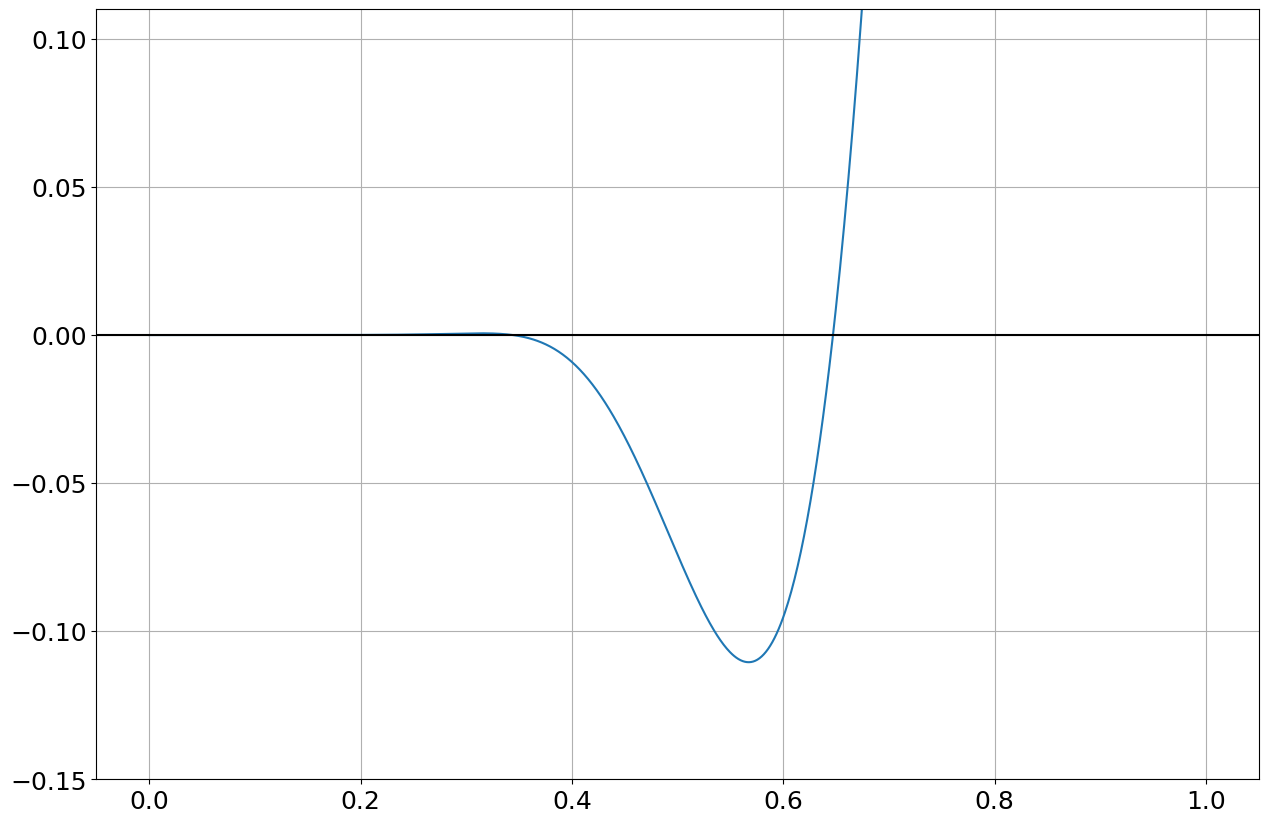

In [96]:
xs = np.linspace(0, 1, 1000)
def eq(x):
    term = np.exp(1 - ((1 / x) ** 2))
    return x ** 9 + 8 * (x ** 2) * term + 3 * (x ** 7) - 4 * term

plt.plot(xs, eq(xs))
plt.grid()
plt.axhline(0, c='k')
plt.ylim(-0.15, 0.11)

In [125]:
((50 / (5e-5)) ** (1 / 3)) * (50000 ** (2 / 3))

135720.88082974523

In [126]:
((50 / (5e-5)) ** (2 / 3)) * (50000 ** (1 / 3))

368403.1498640384